# Data Modeling

# I. Import Libraries and Load Dataset

## 1. Import Libraries

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
import logging

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

optuna.logging.set_verbosity(optuna.logging.WARNING)

## 2. Load Dataset

In [59]:
df = pd.read_csv("../data/processed/processed_data.csv", parse_dates=["timestamp"])

In [60]:
df.head()

,timestamp,city,aqi,pollution_level,pollution_class,temp,humidity,rain,wind_speed,wind_dir,pressure,cloud,pm2_5,pm10,co,no2,o3,so2
0,2023-01-01,Biên Hòa,133,Unhealthy for Sensitive,2,23.0,64,0.0,10.3,12,1010.3,100,65.0,95.0,993.0,84.4,25.0,37.5
1,2023-01-01,Buôn Ma Thuột,53,Moderate,1,17.7,88,0.3,7.7,101,968.4,100,13.6,23.2,485.0,1.8,105.0,2.2
2,2023-01-01,Bắc Ninh,146,Unhealthy for Sensitive,2,11.1,75,0.0,6.2,353,1023.5,0,52.4,74.7,678.0,8.8,58.0,15.4
3,2023-01-01,Cao Bằng,82,Moderate,1,10.8,83,0.0,4.6,162,996.6,100,31.9,45.5,528.0,6.4,45.0,7.6
4,2023-01-01,Cao Lãnh,86,Moderate,1,24.4,55,0.0,12.0,7,1013.9,100,21.8,32.2,693.0,23.0,47.0,3.3


In [61]:
cols_to_drop = ["aqi", "pollution_level", "pollution_class"]
df = df.drop(columns=cols_to_drop, errors="ignore")
# Sort and handle duplicates/resampling
df = df.sort_values(by=["city", "timestamp"])
# Handle duplicates by taking the mean
df = df.groupby(["city", "timestamp"], observed=True).mean(numeric_only=True).reset_index()

In [62]:
df_feat = df.copy()

In [63]:
# Temporal & Social Context
# ==========================================
print("Processing Group 1: Temporal & Social...")

df_feat = df.copy()

# 1.1 Cyclical Hour
df_feat["hour"] = df_feat["timestamp"].dt.hour
df_feat["hour_sin"] = np.sin(2 * np.pi * df_feat["hour"] / 24)
df_feat["hour_cos"] = np.cos(2 * np.pi * df_feat["hour"] / 24)

# 1.2 Day Parts
def get_day_part(h):
    if 5 <= h < 10: return "morning"
    elif 10 <= h < 15: return "midday"
    elif 15 <= h < 18: return "afternoon"
    elif 18 <= h < 23: return "evening"
    else: return "night"

df_feat["day_part"] = df_feat["hour"].apply(get_day_part).astype("category")

# 1.3 Rush Hour
df_feat["is_rush_hour"] = df_feat["hour"].isin([7, 8, 9, 17, 18, 19]).astype(int)

# 1.4 Weekend
df_feat["dayofweek"] = df_feat["timestamp"].dt.dayofweek
df_feat["is_weekend"] = (df_feat["dayofweek"] >= 5).astype(int)

# 1.5 Season
df_feat["month"] = df_feat["timestamp"].dt.month
def month_to_season(m):
    if m in [12, 1, 2]: return "winter"
    elif m in [3, 4, 5]: return "spring"
    elif m in [6, 7, 8]: return "summer"
    else: return "autumn"

df_feat["season"] = df_feat["month"].apply(month_to_season).astype("category")

# Cyclical Month
df_feat["month_sin"] = np.sin(2 * np.pi * df_feat["month"] / 12)
df_feat["month_cos"] = np.cos(2 * np.pi * df_feat["month"] / 12)

# Convert City to Category
df_feat["city"] = df_feat["city"].astype("category")

Processing Group 1: Temporal & Social...


In [64]:
# Physics & Meteorology
# ==========================================
print("Processing Group 2: Physics & Meteo...")

# 2.1 Wind Vector
if "wind_speed" in df_feat.columns and "wind_dir" in df_feat.columns:
    wd_rad = df_feat["wind_dir"] * np.pi / 180
    df_feat["wind_x"] = df_feat["wind_speed"] * np.cos(wd_rad)
    df_feat["wind_y"] = df_feat["wind_speed"] * np.sin(wd_rad)
    df_feat = df_feat.drop(columns=["wind_dir"], errors="ignore")

# 2.2 Cumulative Rain (Washout effect)
if "rain" in df_feat.columns:
    df_feat["rain_sum_6h"] = df_feat.groupby("city", observed=True)["rain"].shift(1).rolling(6).sum().reset_index(0, drop=True)

# 2.3 Temperature Difference 24h (Inversion proxy)
if "temp" in df_feat.columns:
    temp_shifted = df_feat.groupby("city", observed=True)["temp"].shift(1)
    df_feat["temp_diff_24h"] = (
        temp_shifted.rolling(24).max() - temp_shifted.rolling(24).min()
    ).reset_index(0, drop=True)

# 2.4 Humidity-Temperature Interaction
if "humidity" in df_feat.columns and "temp" in df_feat.columns:
    df_feat["humid_x_temp"] = df_feat["humidity"] * df_feat["temp"]

Processing Group 2: Physics & Meteo...


In [65]:
# History & Trend
# ==========================================
print("Processing Group 3: History & Trend...")
target = "pm2_5"

# 3.1 Lag Features
lags = [1, 2, 3, 24]
for lag in lags:
    df_feat[f"pm25_lag_{lag}h"] = df_feat.groupby("city", observed=True)[target].shift(lag)

# 3.2 Rolling Statistics
pm25_shifted = df_feat.groupby("city", observed=True)[target].shift(1)

# Short-term (6h)
df_feat["pm25_rm_6h"] = pm25_shifted.rolling(6).mean().reset_index(0, drop=True)
df_feat["pm25_rs_6h"] = pm25_shifted.rolling(6).std().reset_index(0, drop=True)

# Long-term (24h)
df_feat["pm25_rm_24h"] = pm25_shifted.rolling(24).mean().reset_index(0, drop=True)

# 3.3 Short-term Trend
df_feat["pm25_trend_1h"] = df_feat["pm25_lag_1h"] - df_feat["pm25_lag_2h"]

Processing Group 3: History & Trend...


In [66]:
# Composition
# ==========================================
print("Processing Group 4: Composition...")

if "pm10" in df_feat.columns and "pm2_5" in df_feat.columns:
    # Coarse Dust
    df_feat["coarse_dust"] = df_feat["pm10"] - df_feat["pm2_5"]
    # PM Ratio
    df_feat["pm_ratio"] = df_feat["pm2_5"] / (df_feat["pm10"] + 1e-6)

# Exogenous Lags
exo_cols = ["no2", "so2", "co", "o3", "coarse_dust", "pm_ratio", "pm10"]
for col in exo_cols:
    if col in df_feat.columns:
        df_feat[f"{col}_lag1h"] = df_feat.groupby("city", observed=True)[col].shift(1)

Processing Group 4: Composition...


In [67]:
df_model = df_feat.copy()

# Create Target (Shift -1 hour)
df_model["target_future"] = df_model.groupby("city", observed=True)["pm2_5"].shift(-1)

# Drop NaNs created by lags/rolling/shift
df_model = df_model.dropna()

# Define dates for split
val_start_date = pd.Timestamp("2025-08-01")
test_start_date = pd.Timestamp("2025-10-01")

# Split Data
train = df_model[df_model["timestamp"] < val_start_date]
val = df_model[(df_model["timestamp"] >= val_start_date) & (df_model["timestamp"] < test_start_date)]
test = df_model[df_model["timestamp"] >= test_start_date]

# Separate Features and Target
X_train = train.drop(columns=["timestamp", "target_future"])
y_train = train["target_future"]

X_val = val.drop(columns=["timestamp", "target_future"])
y_val = val["target_future"]

X_test = test.drop(columns=["timestamp", "target_future"])
y_test = test["target_future"]

# Save meta for plotting
test_meta = test[["city", "timestamp", "target_future"]]

print(f"Train Size: {len(X_train)} | Val Size: {len(X_val)} | Test Size: {len(X_test)}")

Train Size: 768672 | Val Size: 49776 | Test Size: 45696


In [68]:
df_model.columns

Index(['city', 'timestamp', 'temp', 'humidity', 'rain', 'wind_speed',
       'pressure', 'cloud', 'pm2_5', 'pm10', 'co', 'no2', 'o3', 'so2', 'hour',
       'hour_sin', 'hour_cos', 'day_part', 'is_rush_hour', 'dayofweek',
       'is_weekend', 'month', 'season', 'month_sin', 'month_cos', 'wind_x',
       'wind_y', 'rain_sum_6h', 'temp_diff_24h', 'humid_x_temp', 'pm25_lag_1h',
       'pm25_lag_2h', 'pm25_lag_3h', 'pm25_lag_24h', 'pm25_rm_6h',
       'pm25_rs_6h', 'pm25_rm_24h', 'pm25_trend_1h', 'coarse_dust', 'pm_ratio',
       'no2_lag1h', 'so2_lag1h', 'co_lag1h', 'o3_lag1h', 'coarse_dust_lag1h',
       'pm_ratio_lag1h', 'pm10_lag1h', 'target_future'],
      dtype='object')

# II. Linear Regression (Baseline Linear Models)


**Linear Regression Overview:** Linear regression is a fundamental statistical and machine learning method used to model the relationship between a dependent variable and one or more independent variables using a linear function. The model assumes that the expected value of the target variable can be expressed as a linear combination of input features, along with an intercept term.

Before moving on to more complex and advanced models, we adopt linear regression as an initial approach. Employing a linear model at this stage allows us to establish a clear baseline for understanding the fundamental relationships between input variables and the target variable, while also providing an initial reference for model performance and interpretability.

During the data exploration process, we observed a strong correlation between PM2.5 and PM10. To address the question of whether PM10 should be retained in the model, we conducted multiple training and evaluation scenarios. These experiments include:
- Retaining all input features
- Removing PM10-related features
- Applying extended linear models such as Ridge Regression, Principal Component Regression (PCR), and Partial Least Squares (PLS).


## 1. Linear Regression with full feature set

**Data Preparation**

In [69]:
X_train_linreg = X_train.copy()
y_train_linreg = y_train.copy()
X_val_linreg = X_val.copy()
y_val_linreg = y_val.copy()
X_test_linreg = X_test.copy()
y_test_linreg = y_test.copy()

### 1.1. Model Training

In [70]:
cat_cols = [
    c for c in X_train_linreg.columns
    if X_train_linreg[c].dtype == "category" or X_train_linreg[c].nunique() < 20
]

num_cols = [c for c in X_train_linreg.columns if c not in cat_cols]

In [71]:
# Linear Regression Pipeline
linear_pipeline1 = Pipeline([
    ("preprocess", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ]
    )),
    ("linreg", LinearRegression(n_jobs=-1))
])
# Train
linear_pipeline1.fit(X_train_linreg, y_train_linreg)
# Validation
val_pred_lin = linear_pipeline1.predict(X_val_linreg)
val_rmse_lin = np.sqrt(mean_squared_error(y_val_linreg, val_pred_lin))
val_mae_lin  = mean_absolute_error(y_val_linreg, val_pred_lin)
# Test
test_pred_lin = linear_pipeline1.predict(X_test_linreg)
test_rmse_lin = np.sqrt(mean_squared_error(y_test_linreg, test_pred_lin))
test_mae_lin  = mean_absolute_error(y_test_linreg, test_pred_lin)
print(f"VAL  RMSE={val_rmse_lin:.4f} MAE={val_mae_lin:.4f}")
print(f"TEST RMSE={test_rmse_lin:.4f} MAE={test_mae_lin:.4f}")

VAL  RMSE=4.0095 MAE=1.9835
TEST RMSE=3.3719 MAE=1.7804


### 1.2. Coefficient Analysis and Feature Importance

In [72]:
lin_model = linear_pipeline1.named_steps["linreg"]
preprocess = linear_pipeline1.named_steps["preprocess"]

# Numeric features
num_features = num_cols

# Categorical features
cat_encoder = preprocess.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(cat_cols)

# Combine all feature names
feature_names = np.concatenate([num_features, cat_features])

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lin_model.coef_
})

coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs_Coefficient", ascending=False)

coef_df.head(5)


,Feature,Coefficient,Abs_Coefficient
6,pm2_5,17.081103,17.081103
7,pm10,12.241782,12.241782
28,coarse_dust,-4.629190,4.629190
20,pm25_lag_1h,-2.920703,2.920703
21,pm25_lag_2h,-2.810490,2.810490


### 1.3. Model Evaluation and Visualization

Evaluating Linear Regression Model...


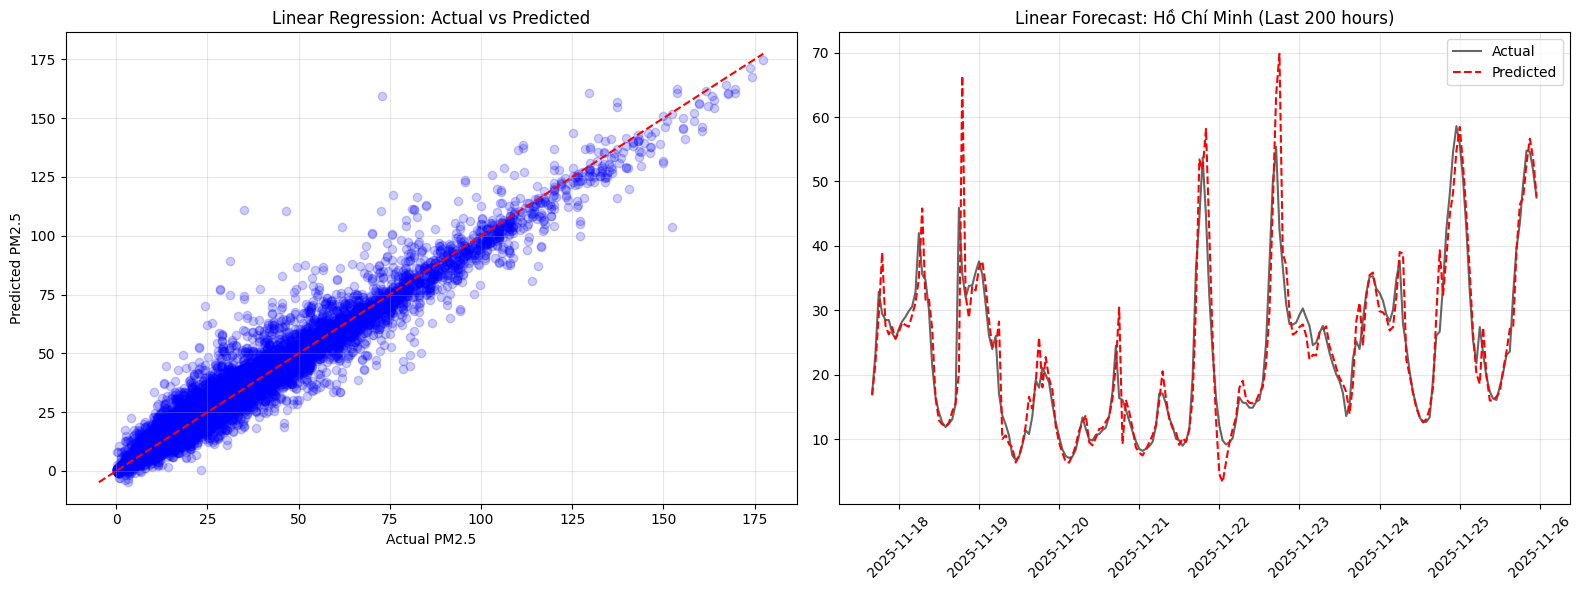

In [73]:
print("Evaluating Linear Regression Model...")

preds = test_pred_lin

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Scatter Plot (Actual vs Predicted)
axes[0].scatter(y_test, preds, alpha=0.2, color="blue")
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
axes[0].plot([min_val, max_val], [min_val, max_val], "r--")
axes[0].set_xlabel("Actual PM2.5")
axes[0].set_ylabel("Predicted PM2.5")
axes[0].set_title("Linear Regression: Actual vs Predicted")
axes[0].grid(True, alpha=0.3)

# Plot B: Forecast for a Sample City
sample_city = "Hồ Chí Minh"

mask = test_meta["city"] == sample_city
if mask.sum() > 0:
    city_dates = test_meta.loc[mask, "timestamp"]
    city_actual = y_test[mask]
    city_preds = preds[mask]

    tail = 200
    axes[1].plot(city_dates[-tail:], city_actual[-tail:], label="Actual", color="black", alpha=0.6)
    axes[1].plot(city_dates[-tail:], city_preds[-tail:], label="Predicted", color="red", linestyle="--")
    axes[1].set_title(f"Linear Forecast: {sample_city} (Last {tail} hours)")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
else:
    axes[1].text(0.5, 0.5, f"City {sample_city} not found", ha="center")

plt.tight_layout()
plt.show()

## 2. Linear Regression after dropping PM10-related features

**Data Preparation**

In [74]:
# Drop PM10-related features
col_drop = ["pm10", "coarse_dust", "pm_ratio", "pm10_lag1h", "coarse_dust_lag1h", "pm_ratio_lag1h"]

X_train_linreg_droppm10 = X_train.copy().drop(columns=col_drop, errors="ignore")
y_train_linreg_droppm10 = y_train.copy()
X_val_linreg_droppm10 = X_val.copy().drop(columns=col_drop, errors="ignore")
y_val_linreg_droppm10 = y_val.copy()
X_test_linreg_droppm10 = X_test.copy().drop(columns=col_drop, errors="ignore")
y_test_linreg_droppm10 = y_test.copy()

### 2.1. Model Training

In [75]:
cat_cols_after_drop = [
    c for c in X_train_linreg_droppm10.columns
    if X_train_linreg_droppm10[c].dtype == "category" or X_train_linreg_droppm10[c].nunique() < 20
]

num_cols_after_drop = [c for c in X_train_linreg_droppm10.columns if c not in cat_cols_after_drop]

In [76]:
# Linear Regression Pipeline
linear_pipeline2 = Pipeline([
    ("preprocess", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols_after_drop),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols_after_drop),
        ]
    )),
    ("linreg", LinearRegression(n_jobs=-1))
])
# Train
linear_pipeline2.fit(X_train_linreg_droppm10, y_train_linreg_droppm10)
# Validation
val_pred_lin_droppm10 = linear_pipeline2.predict(X_val_linreg_droppm10)
val_rmse_lin_droppm10 = np.sqrt(mean_squared_error(y_val_linreg_droppm10, val_pred_lin_droppm10))
val_mae_lin_droppm10  = mean_absolute_error(y_val_linreg_droppm10, val_pred_lin_droppm10)
# Test
test_pred_lin_droppm10 = linear_pipeline2.predict(X_test_linreg_droppm10)
test_rmse_lin_droppm10 = np.sqrt(mean_squared_error(y_test_linreg_droppm10, test_pred_lin_droppm10))
test_mae_lin_droppm10  = mean_absolute_error(y_test_linreg_droppm10, test_pred_lin_droppm10)

print(f"[VAL  RMSE={val_rmse_lin_droppm10:.4f} MAE={val_mae_lin_droppm10:.4f}")
print(f"[TEST RMSE={test_rmse_lin_droppm10:.4f} MAE={test_mae_lin_droppm10:.4f}")

[VAL  RMSE=4.0034 MAE=1.9834
[TEST RMSE=3.3619 MAE=1.7799


### 2.2. Coefficient Analysis and Feature Importance

In [77]:
lin_model = linear_pipeline2.named_steps["linreg"]
preprocess = linear_pipeline2.named_steps["preprocess"]
# Numeric features
num_features = num_cols_after_drop
# Categorical features
cat_encoder = preprocess.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(cat_cols)
# Combine all feature names
feature_names = np.concatenate([num_features, cat_features])

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lin_model.coef_
})

coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs_Coefficient", ascending=False)

coef_df.head(5)

,Feature,Coefficient,Abs_Coefficient
6,pm2_5,26.489020,26.489020
19,pm25_lag_1h,-3.527020,3.527020
20,pm25_lag_2h,-3.392109,3.392109
8,no2,2.679115,2.679115
27,no2_lag1h,-2.331763,2.331763


### 2.3. Model Evaluation and Visualization

Evaluating Linear Regression Model...


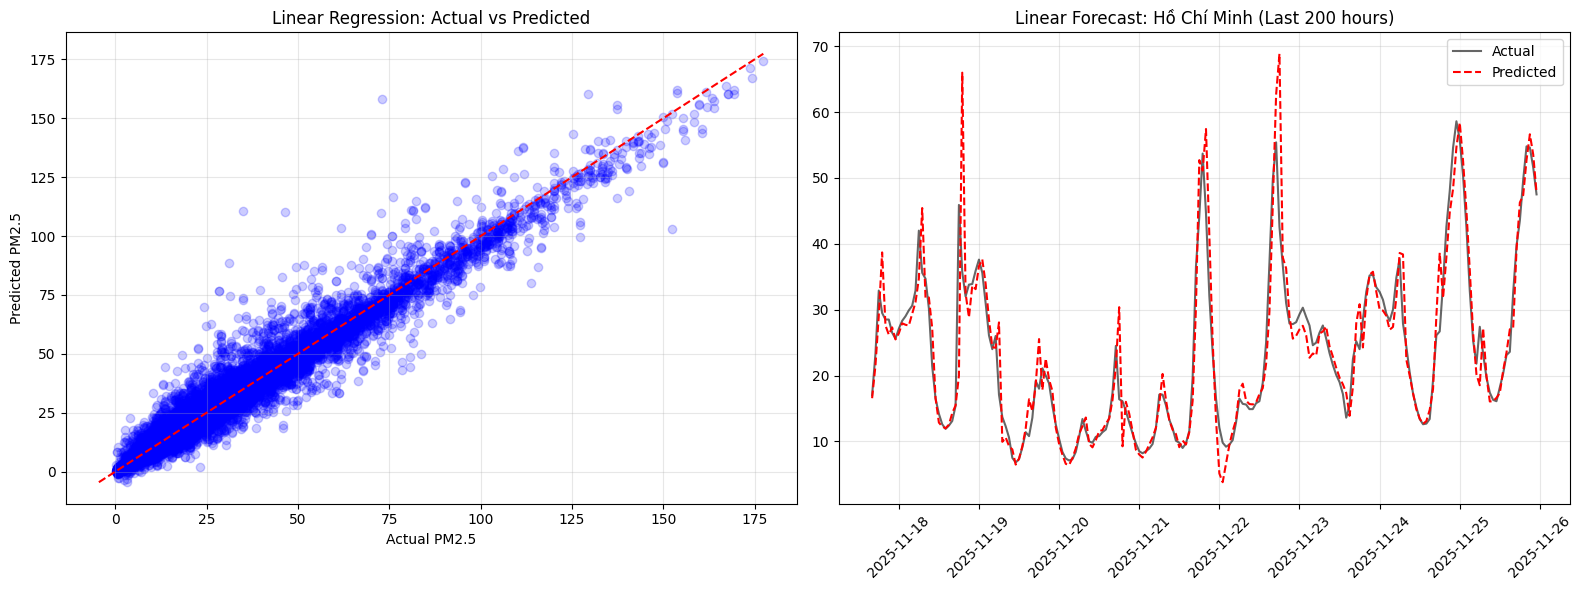

In [78]:
print("Evaluating Linear Regression Model...")

preds = test_pred_lin_droppm10

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Scatter Plot (Actual vs Predicted)
axes[0].scatter(y_test, preds, alpha=0.2, color="blue")
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
axes[0].plot([min_val, max_val], [min_val, max_val], "r--")
axes[0].set_xlabel("Actual PM2.5")
axes[0].set_ylabel("Predicted PM2.5")
axes[0].set_title("Linear Regression: Actual vs Predicted")
axes[0].grid(True, alpha=0.3)

# Plot B: Forecast for a Sample City
sample_city = "Hồ Chí Minh"

mask = test_meta["city"] == sample_city
if mask.sum() > 0:
    city_dates = test_meta.loc[mask, "timestamp"]
    city_actual = y_test[mask]
    city_preds = preds[mask]

    tail = 200
    axes[1].plot(city_dates[-tail:], city_actual[-tail:], label="Actual", color="black", alpha=0.6)
    axes[1].plot(city_dates[-tail:], city_preds[-tail:], label="Predicted", color="red", linestyle="--")
    axes[1].set_title(f"Linear Forecast: {sample_city} (Last {tail} hours)")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
else:
    axes[1].text(0.5, 0.5, f"City {sample_city} not found", ha="center")

plt.tight_layout()
plt.show()


## 3. Extended Linear Models

### 3.1 Ridge Regression

**Ridge Regression Overview:** Ridge Regression is an extension of linear regression that adds an L2 regularization term to the loss function to control the magnitude of regression coefficients. This approach reduces the impact of multicollinearity and improves model stability when input features are highly correlated.

**Data Preparation**

In [79]:
X_train_rid = X_train.copy()
y_train_rid = y_train.copy()
X_val_rid = X_val.copy()
y_val_rid = y_val.copy()
X_test_rid = X_test.copy()
y_test_rid = y_test.copy()

#### 3.1.1. Model Training

In [80]:
print("Training Ridge Regression Model...")
# Ridge Regression Pipeline
ridge_pipeline = Pipeline([
    ("preprocess", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ]
    )),
    ("ridge", Ridge(alpha=10, random_state=42))
])

# Train
ridge_pipeline.fit(X_train_rid, y_train_rid)

# Validation
val_pred_ridge = ridge_pipeline.predict(X_val_rid)
val_rmse_ridge = np.sqrt(mean_squared_error(y_val_rid, val_pred_ridge))
val_mae_ridge  = mean_absolute_error(y_val_rid, val_pred_ridge)

# Test
test_pred_ridge = ridge_pipeline.predict(X_test_rid)
test_rmse_ridge = np.sqrt(mean_squared_error(y_test_rid, test_pred_ridge))
test_mae_ridge  = mean_absolute_error(y_test_rid, test_pred_ridge)

print(f"[Ridge] VAL  RMSE={val_rmse_ridge:.4f} MAE={val_mae_ridge:.4f}")
print(f"[Ridge] TEST RMSE={test_rmse_ridge:.4f} MAE={test_mae_ridge:.4f}")


Training Ridge Regression Model...
[Ridge] VAL  RMSE=4.0092 MAE=1.9834
[Ridge] TEST RMSE=3.3717 MAE=1.7804


#### 3.1.2. Model Evaluation and Visualization

Evaluating Ridge Regression Model...


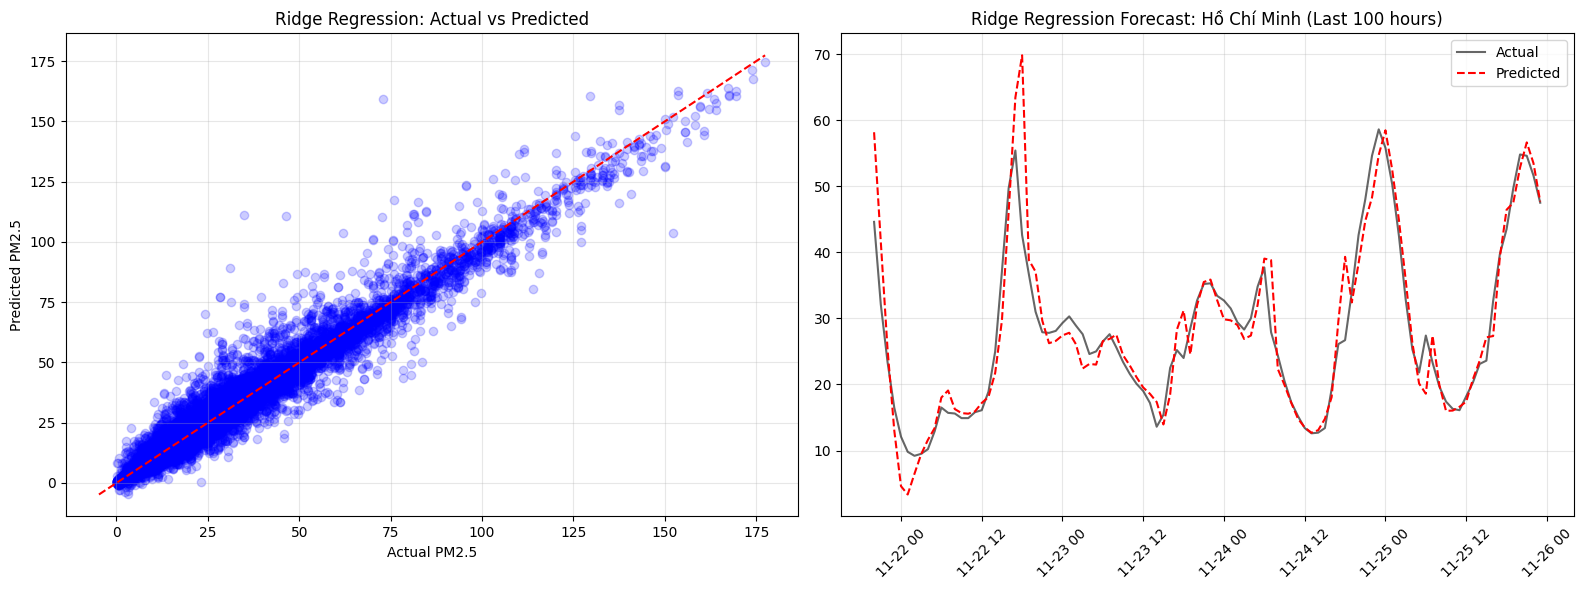

In [81]:
print("Evaluating Ridge Regression Model...")

preds = test_pred_ridge
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: Actual vs Predicted
axes[0].scatter(y_test_rid, preds, alpha=0.2, color="blue")
min_val = min(y_test_rid.min(), preds.min())
max_val = max(y_test_rid.max(), preds.max())
axes[0].plot([min_val, max_val], [min_val, max_val], "r--")
axes[0].set_xlabel("Actual PM2.5")
axes[0].set_ylabel("Predicted PM2.5")
axes[0].set_title("Ridge Regression: Actual vs Predicted")
axes[0].grid(True, alpha=0.3)

# Forecast for a Sample City
sample_city = "Hồ Chí Minh"
mask = test_meta["city"] == sample_city

if mask.sum() > 0:
    city_dates = test_meta.loc[mask, "timestamp"]
    city_actual = y_test_rid[mask]
    city_preds = preds[mask]

    tail = 100
    axes[1].plot(city_dates[-tail:], city_actual[-tail:], label="Actual", color="black", alpha=0.6)
    axes[1].plot(city_dates[-tail:], city_preds[-tail:], label="Predicted", color="red", linestyle="--")
    axes[1].set_title(f"Ridge Regression Forecast: {sample_city} (Last {tail} hours)")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
else:
    axes[1].text(0.5, 0.5, f"City {sample_city} not found", ha="center")

plt.tight_layout()
plt.show()

### 3.2 Principal Component Regression (PCR)

**PCR Overview:** Principal Component Regression (PCR) is a regression approach that combines Principal Component Analysis (PCA) with linear regression. It transforms the original input features into uncorrelated principal components and performs regression on these components to reduce dimensionality and alleviate multicollinearity.

**Data Preparation**

In [82]:
X_train_pcr = X_train.copy()
y_train_pcr = y_train.copy()
X_val_pcr = X_val.copy()
y_val_pcr = y_val.copy()
X_test_pcr = X_test.copy()
y_test_pcr = y_test.copy()

#### 3.2.1. Model Training

In [83]:
print("Training PCR Model...")
# Principal Component Regression (PCR) Pipeline
pcr_pipeline = Pipeline([
    ("preprocess", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ]
    )),
    ("pca", PCA(n_components=90, random_state=42)),
    ("linreg", LinearRegression(n_jobs=-1))
])
# Train
pcr_pipeline.fit(X_train_pcr, y_train_pcr)
# Validation
val_pred_pcr = pcr_pipeline.predict(X_val_pcr)
val_rmse_pcr = np.sqrt(mean_squared_error(y_val_pcr, val_pred_pcr))
val_mae_pcr  = mean_absolute_error(y_val_pcr, val_pred_pcr)
# Test
test_pred_pcr = pcr_pipeline.predict(X_test_pcr)
test_rmse_pcr = np.sqrt(mean_squared_error(y_test_pcr, test_pred_pcr))
test_mae_pcr  = mean_absolute_error(y_test_pcr, test_pred_pcr)
print(f"[PCR] VAL  RMSE={val_rmse_pcr:.4f} MAE={val_mae_pcr:.4f}")
print(f"[PCR] TEST RMSE={test_rmse_pcr:.4f} MAE={test_mae_pcr:.4f}")

Training PCR Model...
[PCR] VAL  RMSE=4.0095 MAE=1.9835
[PCR] TEST RMSE=3.3719 MAE=1.7804


#### 3.2.2. Model Evaluation and Visualization

Evaluating PCR Model...


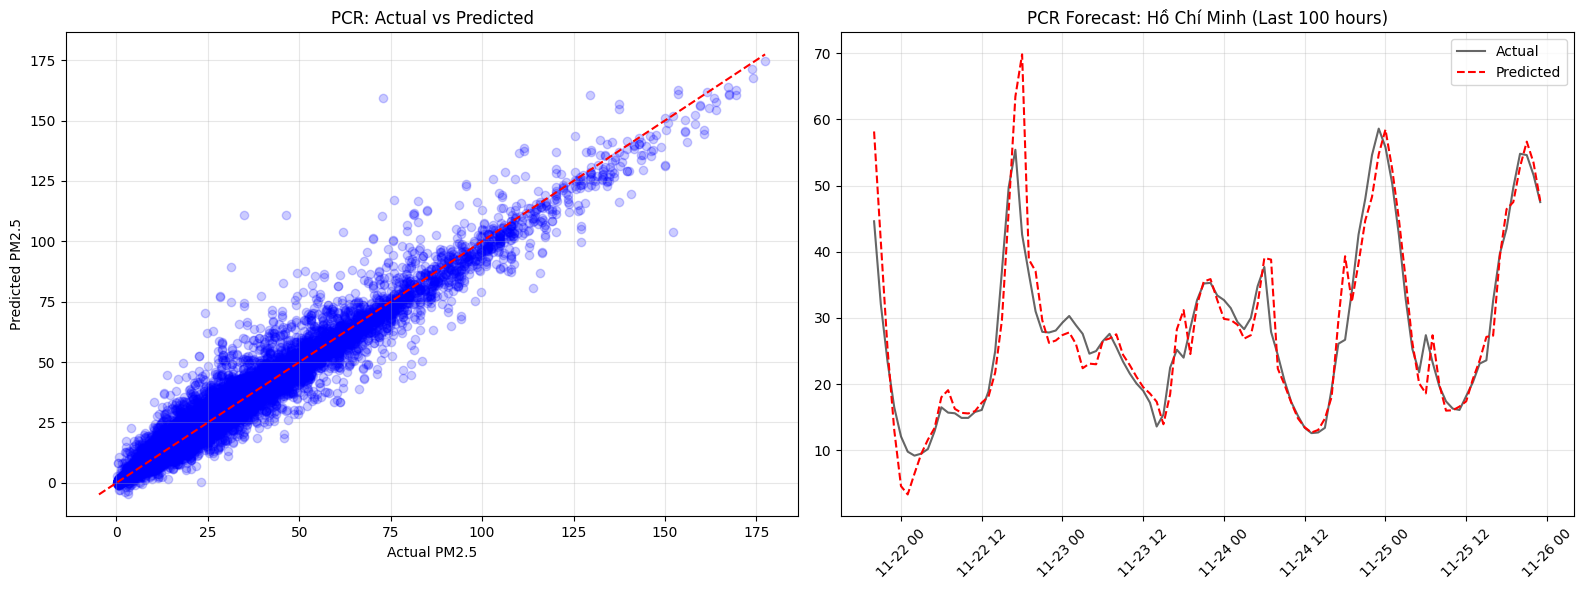

In [84]:
print("Evaluating PCR Model...")

preds = test_pred_pcr
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: Actual vs Predicted
axes[0].scatter(y_test_pcr, preds, alpha=0.2, color="blue")
min_val = min(y_test_pcr.min(), preds.min())
max_val = max(y_test_pcr.max(), preds.max())
axes[0].plot([min_val, max_val], [min_val, max_val], "r--")
axes[0].set_xlabel("Actual PM2.5")
axes[0].set_ylabel("Predicted PM2.5")
axes[0].set_title("PCR: Actual vs Predicted")
axes[0].grid(True, alpha=0.3)

# Forecast for a Sample City
sample_city = "Hồ Chí Minh"
mask = test_meta["city"] == sample_city

if mask.sum() > 0:
    city_dates = test_meta.loc[mask, "timestamp"]
    city_actual = y_test_pcr[mask]
    city_preds = preds[mask]

    tail = 100
    axes[1].plot(city_dates[-tail:], city_actual[-tail:], label="Actual", color="black", alpha=0.6)
    axes[1].plot(city_dates[-tail:], city_preds[-tail:], label="Predicted", color="red", linestyle="--")
    axes[1].set_title(f"PCR Forecast: {sample_city} (Last {tail} hours)")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
else:
    axes[1].text(0.5, 0.5, f"City {sample_city} not found", ha="center")

plt.tight_layout()
plt.show()

### 3.3 Partial Least Squares (PLS)

**PLS Overview:** Partial Least Squares (PLS) is a regression method that constructs latent variables by maximizing the relationship between input features and the target variable. Unlike PCR, PLS considers not only the variance of the input data but also its direct relevance to the dependent variable, often resulting in improved performance when features are highly correlated.

**Data Preparation**

In [85]:
X_train_pls = X_train.copy()
y_train_pls = y_train.copy()
X_val_pls = X_val.copy()
y_val_pls = y_val.copy()
X_test_pls = X_test.copy()
y_test_pls = y_test.copy()

#### 3.3.1. Model Training

In [86]:
print("Training PLS Model...")
# Partial Least Squares (PLS) Regression Pipeline
pls_pipeline = Pipeline([
    ("preprocess", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ]
    )),
    ("pls", PLSRegression(n_components=22))
])
# Train
pls_pipeline.fit(X_train_pls, y_train_pls)
# Validation
val_pred_pls = pls_pipeline.predict(X_val_pls).ravel()
val_rmse_pls = np.sqrt(mean_squared_error(y_val_pls, val_pred_pls))
val_mae_pls  = mean_absolute_error(y_val_pls, val_pred_pls)
# Test
test_pred_pls = pls_pipeline.predict(X_test_pls).ravel()
test_rmse_pls = np.sqrt(mean_squared_error(y_test_pls, test_pred_pls))
test_mae_pls  = mean_absolute_error(y_test_pls, test_pred_pls)
print(f"[PLS] VAL  RMSE={val_rmse_pls:.4f} MAE={val_mae_pls:.4f}")
print(f"[PLS] TEST RMSE={test_rmse_pls:.4f} MAE={test_mae_pls:.4f}")

Training PLS Model...
[PLS] VAL  RMSE=4.0353 MAE=2.0244
[PLS] TEST RMSE=3.3915 MAE=1.8183


#### 3.3.2. Model Evaluation and Visualization

Evaluating PLS Model...


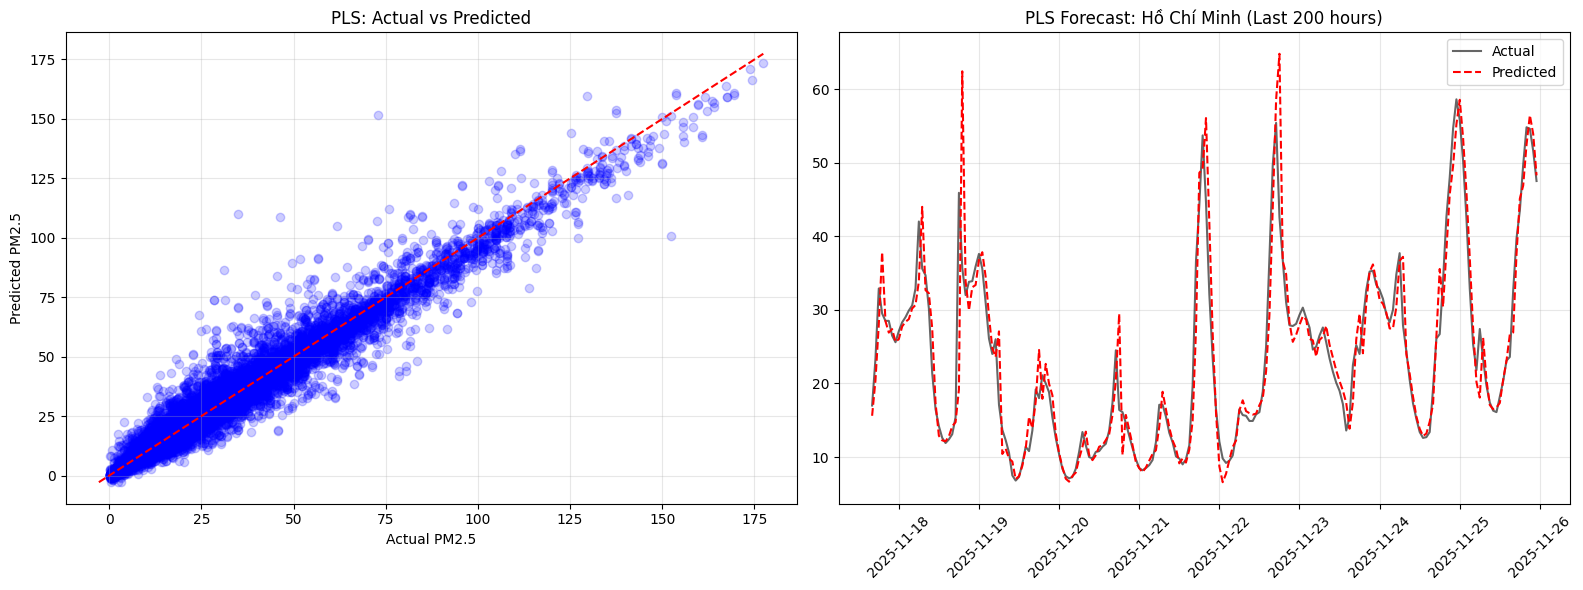

In [87]:
print("Evaluating PLS Model...")

preds = test_pred_pls

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: Actual vs Predicted
axes[0].scatter(y_test, preds, alpha=0.2, color="blue")
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
axes[0].plot([min_val, max_val], [min_val, max_val], "r--")
axes[0].set_xlabel("Actual PM2.5")
axes[0].set_ylabel("Predicted PM2.5")
axes[0].set_title("PLS: Actual vs Predicted")
axes[0].grid(True, alpha=0.3)

# Forecast for a Sample City
sample_city = "Hồ Chí Minh"
mask = test_meta["city"] == sample_city

if mask.sum() > 0:
    city_dates = test_meta.loc[mask, "timestamp"]
    city_actual = y_test[mask]
    city_preds = preds[mask]

    tail = 200
    axes[1].plot(city_dates[-tail:], city_actual[-tail:], label="Actual", color="black", alpha=0.6)
    axes[1].plot(city_dates[-tail:], city_preds[-tail:], label="Predicted", color="red", linestyle="--")
    axes[1].set_title(f"PLS Forecast: {sample_city} (Last {tail} hours)")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
else:
    axes[1].text(0.5, 0.5, f"City {sample_city} not found", ha="center")

plt.tight_layout()
plt.show()
